## Новый код


### Create train and val datasets

In [1]:
import numpy as np

In [518]:
step = 30
im_shape=(401,701)
split_test=0.3
iline, xline = im_shape
vert_locations = np.arange(0, iline, step)
horz_locations = np.arange(0, xline, step)

In [529]:
vert_mask = np.array(vert_locations) // step % round(1 / split_test) == 0
horz_mask = np.array(horz_locations) // step % round(1 / split_test) == 0
p_tr_list = ['i_' + str(ii) for ii in vert_locations[~vert_mask]] + ['x_' + str(ii) for ii in horz_locations[~horz_mask]]
p_vl_list = ['i_' + str(ii) for ii in vert_locations[vert_mask]] + ['x_' + str(ii) for ii in horz_locations[horz_mask]]

In [531]:
vert_mask

array([ True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False])

In [532]:
import random

In [533]:
random.shuffle(p_tr_list)
random.shuffle(p_vl_list)

In [534]:
len(p_tr_list), len(p_vl_list)

(25, 13)

In [535]:
from os.path import join as pjoin
import os

In [536]:
path_data = 'data'

In [537]:
path_splits = pjoin(path_data, 'splits')
    
if not os.path.exists(path_splits):
    os.makedirs(path_splits)

In [538]:
file_object = open(pjoin(path_splits, 'train.txt'), 'w')
file_object.write('\n'.join(p_tr_list))
file_object.close()

file_object = open(pjoin(path_splits, 'val.txt'), 'w')
file_object.write('\n'.join(p_vl_list))
file_object.close()

### Сохраняем пример снимка и меток

In [540]:
# seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
# labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))
# np.save('seismic_example.npy', seismic[0])
# np.save('labels_example.npy', labels[0])
# np.save('seismic_example1.npy', seismic[-1])
# np.save('labels_example1.npy', labels[-1])

### Трансформация (кроп) torchvision transforms

In [541]:
import torch
import torchvision
from torchvision import transforms
import PIL.Image

In [542]:
rand_crop_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(255),
    transforms.Resize((256, 256))
])
'''
Pseudo-code
1. im = ToTensor(im)
2. im, params = RandomCrop(im).get_params()
3. lbl = RandomCrop(lbl, params=params)
4. im = Normalize(im)
5. im = Resize(im, 256x256)
6. lbl = Resize(lbl, 256x256, round=True)  - так, чтобы были целые значения классов или
ТОЧНО!!! Можем предварительно сделать lbl = to_categorical(lbl), тогда метка класса станет массивом вероятностей,
это решит проблему с Resize и не целым значением класа. Нужно ли потом обратно делать np.argmax(axis=-1)????
'''

'\nPseudo-code\n1. im = ToTensor(im)\n2. im, params = RandomCrop(im).get_params()\n3. lbl = RandomCrop(lbl, params=params)\n4. im = Normalize(im)\n5. im = Resize(im, 256x256)\n6. lbl = Resize(lbl, 256x256, round=True)  - так, чтобы были целые значения классов или\nТОЧНО!!! Можем предварительно сделать lbl = to_categorical(lbl), тогда метка класса станет массивом вероятностей,\nэто решит проблему с Resize и не целым значением класа. Нужно ли потом обратно делать np.argmax(axis=-1)????\n'

#### Проверка трансформации

In [543]:
from keras.utils import to_categorical

In [544]:
seismic_example = np.load('seismic_example.npy')
labels_example = np.load('labels_example.npy')
labels_cat_example = to_categorical(labels_example, num_classes=6)

seismic_example1 = np.load('seismic_example1.npy')
labels_example1 = np.load('labels_example1.npy')
labels_cat_example1 = to_categorical(labels_example1, num_classes=6)

In [545]:
labels_cat_example.shape

(701, 255, 6)

In [546]:
np.expand_dims(seismic_example, axis=-1).shape

(701, 255, 1)

In [547]:
stacked = np.dstack([np.expand_dims(seismic_example, axis=-1), labels_cat_example])
stacked = rand_crop_1(stacked)
im, lbl = stacked[0], stacked[1:]
print(im.shape, lbl.shape)

torch.Size([256, 256]) torch.Size([6, 256, 256])


c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [548]:
lbl[lbl % 1 != 0] #.round().int()

tensor([0.1582, 0.1582, 0.9918,  ..., 0.0093, 0.9473, 0.9473],
       dtype=torch.float64)

In [549]:
np.argmax(lbl, axis=0)

tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3]])

In [550]:
seismic_arr = np.array([seismic_example, seismic_example1])
labels_cat_arr = np.array([labels_cat_example, labels_cat_example1])

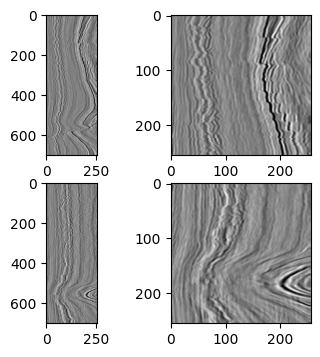

In [551]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(seismic_arr):
    axs[i][0].imshow(image, cmap='gray')
    axs[i][1].imshow(rand_crop_1(image).permute(1,2,0), cmap='gray')
plt.show()

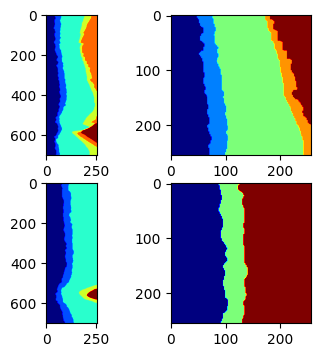

In [552]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(labels_cat_arr):
    axs[i][0].imshow(np.argmax(image,axis =-1), cmap='jet')
    axs[i][1].imshow(np.argmax(rand_crop_1(image).permute(1,2,0), axis=-1), cmap='jet')
plt.show()

In [553]:
seismic_arr.min()

-1.0

In [554]:
labels_cat_arr.max()

1.0

In [555]:
np.stack([image, labels_arr[i]], axis=-1).shape

(701, 255, 6, 2)

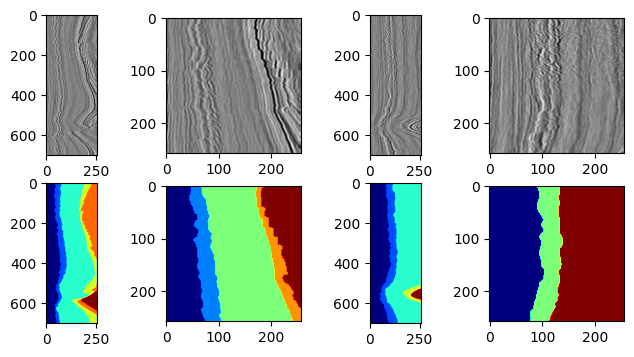

In [556]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
for i, image in enumerate(seismic_arr):
    stacked = np.dstack([np.expand_dims(image, axis=-1), labels_cat_arr[i]])
    stacked = rand_crop_1(stacked)
    im, lbl = stacked[0], stacked[1:]
    axs[0][2*i].imshow(image, cmap='gray')
    axs[0][2*i+1].imshow(im, cmap='gray')
    axs[1][2*i].imshow(np.argmax(labels_cat_arr[i], axis=-1), cmap='jet')
    axs[1][2*i+1].imshow(np.argmax(lbl.permute(1,2,0), axis=-1), cmap='jet')
plt.show()

### Делаем загрузчик данных

In [557]:
import torch
from torch.utils.data import Dataset
from os.path import join as pjoin
import numpy as np
import cv2
from keras.utils import to_categorical

In [558]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [559]:
from torch.backends import cudnn

In [560]:
class MyDataset(Dataset):
    def __init__(self, split='train', loc='data/', transform = None):
        self.root = loc
        self.split = split
        self.n_classes = 6 
        self.transform = transform

        self.seismic = np.load(pjoin(self.root,'train','train_seismic.npy'))
        self.labels  = np.load(pjoin(self.root,'train','train_labels.npy'   ))
        self.labels  = to_categorical(self.labels,num_classes=self.n_classes)

        path = pjoin(self.root, 'splits', self.split + '.txt')
        patch_list = tuple(open(path, 'r'))
        self.patch_list = patch_list

    def __len__(self):
        return len(self.patch_list)
    
    def __getitem__(self, index):
        indexes = self.patch_list[index]
        direction, number = indexes.split(sep='_')
        
        if direction == 'i':
            im = self.seismic[int(number),:,:]
            lbl = self.labels[int(number),:,:,:]
        elif direction == 'x':    
            im = self.seismic[:,int(number),:]
            lbl = self.labels[:,int(number),:,:]
        '''
        if im.shape[0] == 701:
            im = cv2.resize(im,(256,704))
            # lbl = np.argmax(cv2.resize(lbl,(256,704)),axis=-1)
            lbl = np.round(cv2.resize(lbl,(256,704)))
        else:
            im = cv2.resize(im,(256,416))
            # lbl = np.argmax(cv2.resize(lbl,(256,416)),axis=-1)
            lbl = np.round(cv2.resize(lbl,(256,416)))
        '''
        # im = cv2.resize(im,(256,416)) # выбрать единый размер для i и x
        # lbl = np.argmax(cv2.resize(lbl,(256,416)),axis=-1)
        # lbl = np.round(cv2.resize(lbl,(256,416))) # выбрать единый размер
        # im = np.expand_dims(im, axis = 0)

        assert im.shape[1] == 255 and lbl.shape[-1] == 6, f'wrong shapes: {im.shape} and {lbl.shape}'

        if self.transform:
            stacked = np.dstack([np.expand_dims(im, axis=-1), lbl])
            stacked = rand_crop_1(stacked)
            im, lbl = stacked[0], stacked[1:]

        if isinstance(im, np.ndarray):
            im = torch.from_numpy(im)
        if isinstance(lbl, np.ndarray):
            lbl = torch.from_numpy(lbl)

        image_tensor = torch.unsqueeze(im, 0)
        image_tensor = image_tensor.float()
        label_tensor = lbl.float() # или всё-таки int()??? если int, то тогда надо сделать round

        return image_tensor, label_tensor

In [561]:
train_dataset = MyDataset(split='train', transform=rand_crop_1)
val_dataset = MyDataset(split='val', transform=rand_crop_1)

In [562]:
len(train_dataset), len(val_dataset)

(25, 13)

In [578]:
batch_size = 8
num_epochs = 30

In [564]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Проверка DataLoader-ов

In [566]:
image_tensor, label_tensor = next(iter(train_loader))
len(train_loader)

c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


4

In [567]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 6, 256, 256]))

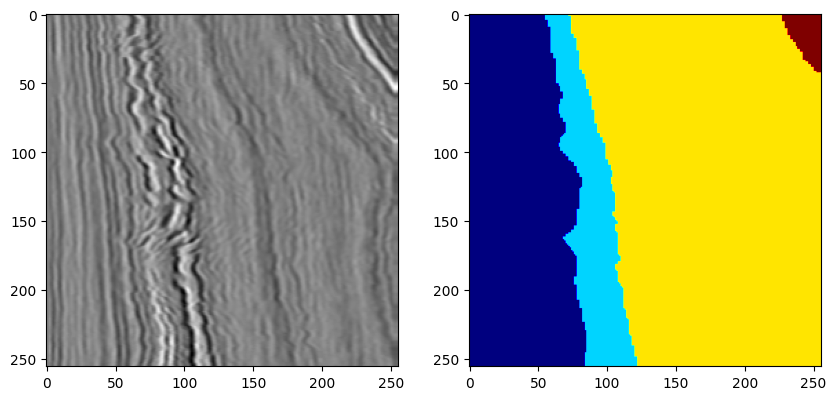

In [568]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(label_tensor[0,:,:,:],axis=0), cmap='jet')
plt.show()

In [569]:
image_tensor.max(), image_tensor.min() # нормировка должна быть внутри класса

(tensor(1.), tensor(-1.))

### Моделька

In [605]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [606]:
len(train_loader), len(val_loader)

(4, 2)

In [607]:
# Создаем U-Net модель с энкодером resnet34
model = smp.Unet(
    encoder_name="resnet18", # resnet18 
    encoder_weights="swsl", # можно обучать с нуля
    in_channels=1,
    classes=6  # Количество классов для сегментации
)

### Loss, merics, optimizer

In [608]:
import segmentation_models_pytorch.utils

In [609]:
# # Определяем функцию потерь и оптимизатор
loss = [smp.utils.losses.DiceLoss(), nn.CrossEntropyLoss()] # указать количество классов?
metrics = [smp.utils.metrics.IoU(threshold=0.7)] # threshold ?? 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# loss = [smp.losses.DiceLoss('multiclass'), smp.losses.SoftCrossEntropyLoss()]
# metrics = smp.metrics.iou_score

In [610]:
# Определяем устройство для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [611]:
# Переносим модель и функцию потерь на устройство
model = model.to(device)
loss[0] = loss[0].to(device)
loss[1] = loss[1].to(device)

### Learning

In [612]:
from tqdm import tqdm

In [615]:
if not os.path.exists('disasters_1/'):
    os.makedirs('disasters_1/')

In [616]:
best_metric = 0
best_model = model

In [617]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Обучение
    model.train()
    # i = 0
    # train_bar = tqdm(train_loader, desc='Training', leave=False)
    for i, (images, labels) in enumerate(train_loader):
        # print(f'input shape = {(images.shape, labels.shape)}')
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images

        outputs = model(images)
        # print(f'output shape = {(outputs.shape)}')
        # print(f'lab_cat shape = {labels.shape}')
        # print(outputs[0,:,0,:10])
        # print(labels[0,0,:10,:])

        loss_value = loss[0](outputs, labels.reshape(outputs.shape)) + loss[1](outputs, labels.reshape(outputs.shape))
        loss_value.backward()
        optimizer.step()

        if loss_value.item() < 0:
            np.save(f'disasters_1/nl_output_{epoch}_{i}.npy', outputs.detach().numpy())

        # i += 1
        # train_bar.set_postfix(training_step=i)
    
    # Валидация
    model.eval()
    total_metric = 0
    num_samples = 0
    # val_bar = tqdm(val_loader, desc='Validation', leave=False)
    # i = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)
            metric_value = metrics[0](outputs, labels.reshape(outputs.shape))
            total_metric += metric_value.item() * images.size(0)
            num_samples += images.size(0)
        # i += 1
        # val_bar.set_postfix(training_step=i)
    
    average_metric = total_metric / num_samples
    
    # Вывод прогресса обучения
    # print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_value.item():.4f}, Metric: {average_metric:.4f}')

    # сохранение чекпойнта (если метрика стала лучше)
    if best_metric < average_metric:
        best_metric = average_metric
        best_model = model

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epochs: 100%|██████████| 30/30 [07:11<00:00, 14.40s/it]


In [626]:
best_metric

0.6861106340701764

In [ ]:
# отрицательный loss - понять причину
# сохр инпут,аут если лосс отрицательный
# вместо diceloss -> diceloss + crossentropy
# надо считать loss на train и на val, сохранять их
# tensorboard - для отслеживания обучения

In [618]:
torch.save(best_model.state_dict(), "model_2829_2.pth")

In [627]:
model.load_state_dict(torch.load("model_2829_2.pth"))

<All keys matched successfully>

In [628]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [629]:
image_tensor, label_tensor = next(iter(train_loader))

c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [633]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 6, 256, 256]))

In [630]:
output = model(image_tensor)
output = output.detach().numpy()

In [641]:
np.dstack([label_tensor[i,:,:,:], output[i,:,:,:]]).shape

(6, 256, 512)

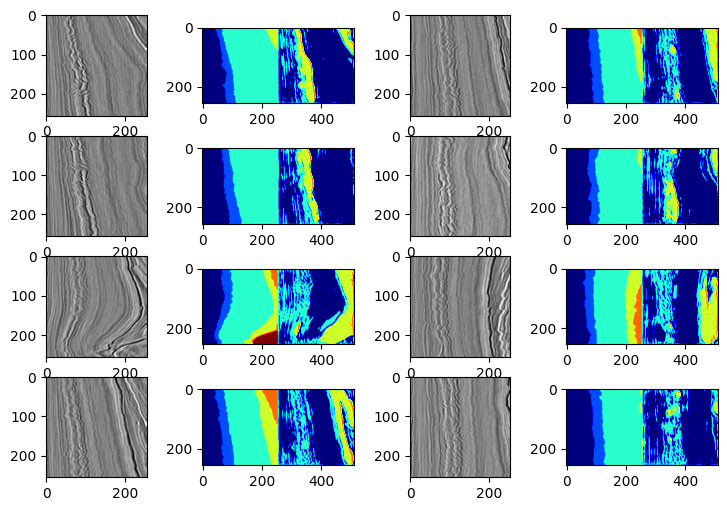

In [642]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9,6))
for i in range(image_tensor.shape[0]):
    axs[i // 2][i % 2 * 2].imshow(image_tensor[i,0,:,:], cmap='gray')
    # axs[i // 2][i % 2 * 2 + 1].imshow(np.argmax(label_tensor[i,:,:,:],axis=0), cmap='jet')
    # axs[i // 2][i % 2 * 2 + 1].imshow(np.argmax(output[i,:,:,:],axis=0), cmap='jet')
    all_labels = np.dstack([label_tensor[i,:,:,:], output[i,:,:,:]])
    axs[i // 2][i % 2 * 2 + 1].imshow(np.argmax(all_labels,axis=0), cmap='jet')
plt.show()

In [515]:
disaster = np.load('nl_output_6_1.npy')

In [517]:
disaster.min(), disaster.max(), np.isnan(disaster).any()

(-38.534443, 27.61486, False)

### Тестируем на полном срезе

In [643]:
seismic_example1.shape, labels_cat_example1.shape

((701, 255), (701, 255, 6))

In [912]:
def test_i_sample(seismic_i, labels_cat_i):
    idxs = [(0, 255), (223, 478), (446, 701)]
    im_parts = np.zeros((3,255,255))
    lbl_parts = np.zeros((3,6,255,255))
    for i, idx in enumerate(idxs):
        im_parts[i] = seismic_i[idx[0]:idx[1]]
        assert im_parts[i].shape == (255, 255), f'Wrong shape of im[{i}]: {im_parts[i].shape}'
        lbl_parts[i] = np.moveaxis(labels_cat_i[idx[0]:idx[1]], -1, 0)
        assert lbl_parts[i].shape == (6, 255, 255), f'Wrong shape of lbl[{i}]: {lbl_parts[i].shape}'
    input_tensor = transforms.Resize((256, 256))(transforms.ToTensor()(im_parts[0]))
    outputs = np.zeros((3, 6, 256, 256))
    for i, im_part in enumerate(im_parts):
        input_tensor = transforms.Resize((256, 256))(transforms.ToTensor()(im_part))
        output = model(torch.unsqueeze(input_tensor.float(), 0))
        outputs[i:i+1] = output.detach().numpy()
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6,3))
    for i, output in enumerate(outputs):
        axs[0][i % 3].imshow(im_parts[i,:,:], cmap='gray')
        axs[1][i % 3].imshow(np.argmax(lbl_parts[i],axis=0), cmap='jet')
        axs[2][i % 3].imshow(np.argmax(output,axis=0), cmap='jet')
    plt.show()
    all_parts_idxs = np.zeros((5, 2), dtype=int)
    all_parts_idxs[0] = [idxs[0][0], idxs[1][0]]
    all_parts_idxs[1] = [idxs[1][0], idxs[0][1]]
    all_parts_idxs[2] = [idxs[0][1], idxs[2][0]]
    all_parts_idxs[3] = [idxs[2][0], idxs[1][1]]
    all_parts_idxs[4] = [idxs[1][1], idxs[2][1]]
    pairs = []
    pairs.append(all_parts_idxs[0] - all_parts_idxs[0][0])
    pairs.append(all_parts_idxs[1] - all_parts_idxs[0][0])
    pairs.append(all_parts_idxs[1] - all_parts_idxs[1][0])
    pairs.append(all_parts_idxs[2] - all_parts_idxs[1][0])
    pairs.append(all_parts_idxs[3] - all_parts_idxs[1][0])
    pairs.append(all_parts_idxs[3] - all_parts_idxs[3][0])
    pairs.append(all_parts_idxs[4] - all_parts_idxs[3][0])
    scaled_outputs = np.zeros((3, 255, 255, 6))
    for i, output in enumerate(outputs):
        scaled_outputs[i] = cv2.resize(np.moveaxis(output, 0, -1),(255, 255))
    full_output = np.zeros(labels_cat_i.shape)
    full_output[all_parts_idxs[0][0]:all_parts_idxs[0][1]] = scaled_outputs[0][pairs[0][0]:pairs[0][1]]
    full_output[all_parts_idxs[1][0]:all_parts_idxs[1][1]] = (scaled_outputs[0][pairs[1][0]:pairs[1][1]] + scaled_outputs[1][pairs[2][0]:pairs[2][1]]) / 2
    full_output[all_parts_idxs[2][0]:all_parts_idxs[2][1]] = scaled_outputs[1][pairs[3][0]:pairs[3][1]]
    full_output[all_parts_idxs[3][0]:all_parts_idxs[3][1]] = (scaled_outputs[1][pairs[4][0]:pairs[4][1]] + scaled_outputs[2][pairs[5][0]:pairs[5][1]]) / 2
    full_output[all_parts_idxs[4][0]:all_parts_idxs[4][1]] = scaled_outputs[2][pairs[6][0]:pairs[6][1]]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,6))
    axs[0].imshow(seismic_i, cmap='gray')
    axs[1].imshow(np.argmax(labels_cat_i,axis=-1), cmap='jet')
    axs[2].imshow(np.argmax(full_output, axis=-1), cmap='jet')
    plt.show()

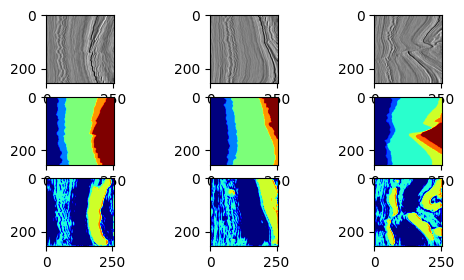

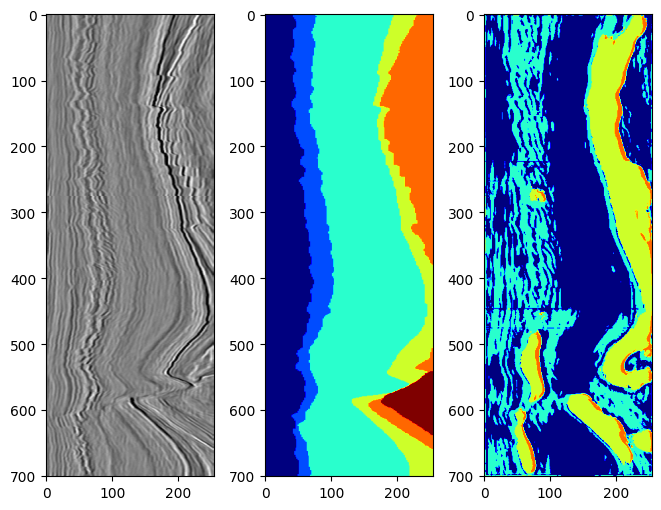

In [914]:
test_i_sample(seismic_example, labels_cat_example)

c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


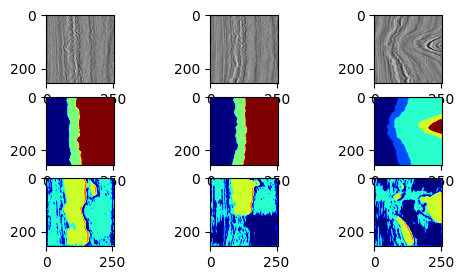

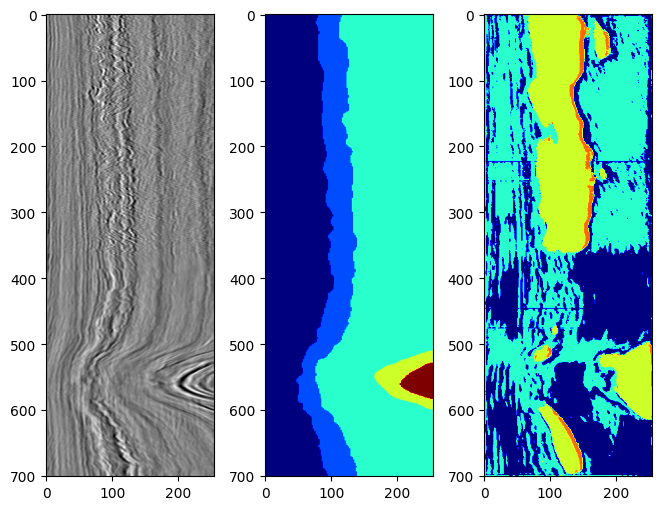

In [913]:
test_i_sample(seismic_example1, labels_cat_example1)